# HHL算法求解线性方程组

## 1. 简介

线性方程组在整个科学和工程领域无处不在，在每个研究领域，高效地操作矩阵已成为一个巨大的兴趣领域。它们自然地出现在许多现实应用中，如偏微分方程的求解、金融模型的校准、流体模拟或数值场计算等广泛领域。

如果矩阵A每行或每列最多具有s个非零元，则将线性方程组称为s-稀疏线性方程组。

用Aram Harrow、Avinatan Hassidim和Seth Lloyd开发的HHL是一种量子算法来解决 N 维的s-稀疏线性方程组，它的运行时间复杂度为 $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$ [1]。其中$\epsilon$表示近似的精度。

用经典算法（共轭梯度法）来解决 N 维的s-稀疏线性方程组，需要的时间复杂度为 $\mathcal{O}(Ns\kappa\log(1/\epsilon))$ [2]。

线性方程组问题可定义为，给定一个矩阵 $A\in\mathbb{C}^{N\times N}$ 和一个向量 $\vec{b}\in\mathbb{C}^{N}$ ，求 $\vec{x}\in\mathbb{C}^{N}$ 满足 $A\vec{x}=\vec{b}$ 。

例如，取 $N=2$ ，
$$A = \begin{pmatrix}a_{11} & a_{12}\\a_{21} & a_{22} \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\\ x_{2}\end{pmatrix}\quad \text{and} \quad \vec{b}=\begin{pmatrix}b_1 \\ b_2\end{pmatrix}$$

因此，问题可以写成寻找 $x_{1}， x_{2}\in\mathbb{C}$ 使得
$$\begin{cases}a_{11}x_{1} + a_{12}x_{2} = b_1 \\ a_{21}x_{1} + a_{22}x_{2} = b_2\end{cases} $$


## 2. HHL算法背景

用量子计算机求解线性方程组的第一步是将问题编码成量子语言。通过重新缩放系统，我们可以假设 $\vec{b}$ 和 $\vec{x}$ 被归一化并映射到各自的量子态 $|b\rangle$ 和 $|x\rangle$ 。通常使用的映射是 $\vec{b}$ 的第$i$个分量（相应地， $\vec{x}$ 的第 $i$ 个分量）对应于量子态 $|b\rangle$ （相应地， $|x\rangle$ ）的第 $i$ 个基态的幅值。从现在开始，我们将专注于重新缩放的问题
$$ A|x\rangle=|b\rangle$$

由于 $A$ 是厄米矩阵，它具有谱分解  
$$
A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\quad \lambda_{j}\in\mathbb{ R }
$$
其中 $|u_{j}\rangle$ 是 $A$ 的第 $j$ 个特征向量，相应的特征值为 $\lambda_{j}$ 。它可以写成其特征向量的外积之和，按特征值缩放。因此，我们可以将 $A$ 的逆写成
$$
A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}|
$$ 
由于 $A$ 是可逆和厄米的，它必须具有正交的特征向量基，因此我们可以在 $A$ 的特征基下写出 $b$   
$$
|b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j}\rangle,\quad b_{j}\in\mathbb{ C }
$$

请记住，HHL算法的目标是在读出寄存器处于以下状态时退出算法
$$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle
$$
请注意，这里我们已经有了一个隐式归一化常数，因为我们在讨论一个量子态。

## 3. HHL算法原理

该算法使用三个量子寄存器，在算法开始时它们都被置为 $|0\rangle$ 。我们用下标 $n_{l}$ 表示的一个寄存器用于存储 $A$ 的特征值的二进制表示。第二个寄存器用 $n_{b}$ 表示，包含向量解，从现在开始 $N=2^{n_{b}}$ 。还有一个额外的寄存器用于辅助量子比特。这些量子比特用作单个计算中的中间步骤，但在下面的描述中将被忽略，因为它们在每个计算开始时被置为 $|0\rangle$ ，并在单个操作结束时恢复为 $|0\rangle$ 状态。

1. 加载数据 $|b\rangle\in\mathbb{C}^{N}$ 。即执行转换
   $$ |0\rangle _{n_{b}} \mapsto |b\rangle _{n_{b}} $$

2. 应用量子相位估计(QPE)，其中
   $$
   U = e ^ { i A t } := \sum _{j=0}^{N-1}e ^ { i \lambda _ { j } t } |u_{j}\rangle\langle u_{j}|
   $$
   寄存器的量子态在 $A$ 的特征基下表示为
   $$
   \sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
   $$
   其中 $|\lambda_{j}\rangle_{n_{l}}$ 是 $\lambda_{j}$ 的 $n_{l}$ 比特二进制表示。

3. 添加一个辅助量子比特，并应用一个以 $|\lambda_{j}\rangle$ 为条件的旋转，
   $$
   \sum_{j=0}^{N-1} b _ { j } |\lambda _ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac { C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
   $$
   其中 $C$ 是归一化常数，如上式所示，它的大小应小于最小特征值 $\lambda_{min}$,即$|C|<\lambda_{min}$ 。

4. 应用QPE $^{\dagger}$ 。忽略QPE可能产生的误差，结果为
   $$
   \sum_{j=0}^{N-1} b _ { j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
   $$

5. 在计算基底下测量辅助量子比特。如果结果为 $1$ ，则寄存器处于后测量态
   $$
   \left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum _{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} 
   $$
   这对应于归一化因子的解。

6. 应用一个可观测量 $M$ 来计算 $F(x):=\langle x|M|x\rangle$ 。

## 4. HHL中的量子相位估计(QPE)

量子相位估计是一种量子算法，给定特征向量为 $|\psi\rangle_{m}$ 、特征值为 $e^{2\pi i\theta}$ 的幺正算符 $U$ ,可以找到 $\theta$ 。我们可以正式定义如下。

**定义:** 设 $U\in\mathbb{C}^{2^{m}\times 2^{m}}$ 为幺正算符， $|\psi\rangle_{m}\in\mathbb{C}^{2^{m}}$ 为其特征向量之一，对应的特征值为 $e^{2\pi i\theta}$ 。**量子相位估计**算法（简称**QPE**）以幺正门 $U$ 和态 $|0\rangle_{n}|\psi\rangle_{m}$ 作为输入，返回态 $|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}$ 。这里 $\tilde{\theta}$ 表示对 $2^{n}\theta$ 的二进制近似，下标 $n$ 表示它已被截断为 $n$ 位数。

$$
\operatorname{QPE}(U,|0\rangle_{n}|\psi\rangle_{m})=|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}
$$

对于HHL，我们将使用 $U=e^{iAt}$ 的QPE，其中 $A$ 是我们要求解的系统的矩阵。在这种情况下，

$$
e^{iAt}=\sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j}|
$$

然后，对于特征值为 $e^{i\lambda_{j}t}$ 的特征向量 $|u_{j}\rangle_{n_{b}}$ ，QPE将输出 $|\tilde{\lambda}_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$ 。其中 $\tilde{\lambda}_{j}$ 表示对 $2^{n_l}\frac{\lambda_{j}t}{2\pi}$ 的 $n_{l}$ 位二进制近似。因此，如果每个 $\lambda_{j}$ 都可以用 $n_{l}$ 位精确表示，则

$$
\operatorname{QPE}(e^{iAt},\sum_{j=0}^{N-1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}})=\sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$

## 5. 非精确QPE

在对初态应用QPE后，寄存器的量子态为

$$
\sum_{j=0}^{N-1}b_{j}\left(\sum_{l=0}^{2^{n_{l}}-1}\alpha_{l|j}|l\rangle_{n_{l}}\right)|u_{j}\rangle_{n_{b}}
$$

其中

$$
\alpha_{l|j}=\frac{1}{2^{n_{l}}}\sum_{k=0}^{2^{n_{l}}-1}\left(e^{2\pi i\left(\frac{\lambda_{j}t}{2\pi}-\frac{l}{2^{n_{l}}}\right)}\right)^{k}
$$

用 $\tilde{\lambda_{j}}$ 表示对 $\lambda_{j}$ 的最佳 $n_{l}$ 位近似， $1\leq j\leq N$ 。然后我们可以重新标记 $n_{l}$ 寄存器，使得 $\alpha_{l|j}$ 表示 $|l+\tilde{\lambda}_{j}\rangle_{n_{l}}$ 的振幅。现在，

$$
\alpha_{l|j}:=\frac{1}{2^{n_{l}}}\sum_{k=0}^{2^{n_{l}}-1}\left(e^{2\pi i\left(\frac{\lambda_{j}t}{2\pi}-\frac{l+\tilde{\lambda}_{j}}{2^{n_{l}}}\right)}\right)^{k}
$$

如果每个 $\frac{\lambda_{j}t}{2\pi}$ 都可以用 $n_{l}$ 位二进制精确表示，则 $\frac{\lambda_{j}t}{2\pi}=\frac{\tilde{\lambda}_{j}}{2^{n_{l}}},\forall j$ 。因此，在这种情况下， $\forall j,1\leq j\leq N$ ，有 $\alpha_{0|j}=1$ 且 $\alpha_{l|j}=0,\forall l\neq0$ 。只有在这种情况下，我们可以写出QPE后寄存器的状态为

$$
\sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$ 

否则，当且仅当 $\frac{\lambda_{j}t}{2\pi}\approx\frac{l+\tilde{\lambda}_{j}}{2^{n_{l}}}$ 时，| $\alpha_{l|j}|$ 很大，寄存器的状态为

$$
\sum_{j=0}^{N-1}\sum_{l=0}^{2^{n_{l}}-1}\alpha_{l|j}b_{j}|l\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$

## 6. 代码示例

In [2]:
from typing import Any, List, Optional, Union
import torch 
import deepquantum as dq
import numpy as np
from scipy.linalg import expm
class QuantumFourierTransform(dq.Ansatz):
    def __init__(
        self,
        nqubit: int,
        wires: Optional[List[int]] = None,
        reverse: bool = False,
        init_state: Any = 'zeros',
        den_mat: bool = False,
        mps: bool = False,
        chi: Optional[int] = None,
        show_barrier: bool = False
    ) -> None:
        super().__init__(nqubit=nqubit, wires=wires, minmax= None, ancilla=None, controls=None,
                         init_state=init_state, name='QuantumFourierTransform', den_mat=den_mat,
                         mps=mps, chi=chi)
        self.reverse = reverse
        for i in self.wires:
            self.qft_block(i)
            if show_barrier:
                self.barrier(self.wires)
        if not reverse:
            for i in range(len(self.wires) // 2):
                self.swap([self.wires[i], self.wires[-1 - i]])

    def qft_block(self, n):
        self.h(n)
        k = 2
        for i in range(n, self.minmax[1]):
            self.cp(i + 1, n, torch.pi / 2 ** (k - 1))
            k += 1


class QuantumPhaseEstimation(dq.Ansatz):
    def __init__(
        self,
        nqubit: int,
        unitary: Any,
        t: int,
        t_a: int,
        wires: Optional[List[int]] = None,
        den_mat: bool = False,
        mps: bool = False,
        chi: Optional[int] = None
    ) -> None:
        self.unitary=unitary
        super().__init__(nqubit=nqubit, wires=wires, minmax=None, ancilla=None, controls=None,
                         init_state='zeros', name='QuantumPhaseEstimationQubit', den_mat=den_mat,
                         mps=mps, chi=chi)
  
        self.hlayer(list(wires[0:t]))
        self.barrier()
        
        for i in wires[0:t]:
            self.any(unitary=np.linalg.matrix_power(self.unitary, 2 ** (t - i)),wires=list(range(t+1,nqubit)), controls=i)
        
        self.barrier()        
        iqft = QuantumFourierTransform(nqubit=nqubit, wires=wires[0:t],den_mat=self.den_mat, mps=self.mps, chi=self.chi).inverse()
        self.add(iqft)



class HHL(dq.Ansatz):
    def __init__(
        self,
        unitary: Any,
        t: int,  #qubit_measurement_num
        t_a: int, #qubit_auxiliary_num
        minmax: Optional[List[int]] = None,
        den_mat: bool = False,
        mps: bool = False,
        chi: Optional[int] = None,
        dt: float = 1  # #旋转线路需要根据矩阵的特征值确定 时间间隔 dt,默认为1
    ) -> None:
        self.nqubit = 1 + t + t_a
        self.unitary=unitary
        super().__init__(nqubit=self.nqubit, wires=None, minmax=None, ancilla=None, controls=None,
                         init_state='zeros', name='HHL', den_mat=den_mat,
                         mps=mps, chi=chi)

        # #旋转线路需要根据矩阵的特征值确定 时间间隔 dt
        U_A = expm(dt*1j*unitary*2*np.pi/(2**t))
        
        iqpe = QuantumPhaseEstimation(nqubit=self.nqubit,unitary=U_A,t=qubit_measurement_num, t_a=qubit_auxiliary_num,wires=list(range(1,self.nqubit)))
        self.add(iqpe)
        self.barrier()     
        
        # #旋转线路需要根据矩阵的特征值确定        
        for i in range(2**t):
            for j in range(t):
                if format(i, '0' + str(t) + 'b')[t-j-1]=='0':
                    self.x(1+j)   
            self.ry(0,inputs=2*torch.pi*(i)/(2**t),controls=list(range(1,t+1)))
            for j in range(t):
                if format(i, '0' + str(t) + 'b')[t-j-1]=='0':
                    self.x(1+j)      
            self.barrier() 

        iqpe_dg = QuantumPhaseEstimation(nqubit=self.nqubit,unitary=U_A,t=qubit_measurement_num, t_a=qubit_auxiliary_num,wires=list(range(1,self.nqubit))).inverse()
        self.add(iqpe_dg)
        self.barrier()
        
        self.measure(wires=list(range(self.nqubit)))


假设：

$$A = \begin{pmatrix}4 & 1\\1 & 4 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} 1\\ 1\end{pmatrix}\quad$$

In [3]:
## 该网络模型可用于特征值为整数的酉矩阵A，如果特征值不是整数，需要调节合适的dt值，用于U演化。
# 例子
qubit_measurement_num=4      ## 定义测量比特数，测量比特的数量影响测量相位的精度。
qubit_auxiliary_num=1    ## 定义辅助比特数，辅助比特的数量对应测量的酉矩阵大小。
qubit_num=1+qubit_measurement_num+qubit_auxiliary_num  ##总比特数
A = np.mat([[4,1], [1,4]])   # A酉矩阵，特征值为5,3
b =  [1, 1]   # b向量
dt = 1 #设置dt时，要保证(2^qubit_measurement_num)*(A的所有特征值)*dt 为整数。

hhl=HHL(unitary=A,t=qubit_measurement_num, t_a=qubit_auxiliary_num,dt=dt)
state = dq.QubitState(1+qubit_measurement_num+qubit_auxiliary_num, state=b).state
res=hhl(state=state)

counts = hhl.measure(wires=list(range(qubit_num)),shots=100000)
print(counts)

{'100001': 42636, '100000': 42598, '000001': 7431, '000000': 7335}


计算HHL算法的保真度：

In [4]:
# 计算投点的保真度结果
p = np.zeros([len(b),1])
for i in range(len(b)):
    try:
        p[i]=counts['1'+'0'*qubit_measurement_num+format(i, '0' + str(qubit_auxiliary_num) + 'b')]
    except:
        p[i]=0
ss=sum(p)

p=p/ss
print("量子投点概率计算："+str(p))

## 计算准确的解
x= np.linalg.inv(A)@np.mat(b).T
x = np.array(x)
# 将准确的解
x = x**2/sum(x**2)
print("准确值："+str(x))

fidelity = 0
for i in range(2**qubit_auxiliary_num):
    fidelity = np.sqrt(x[i]*p[i]) + fidelity
fidelity = fidelity**2 
print("保真度："+str(fidelity))

量子投点概率计算：[[0.49977708]
 [0.50022292]]
准确值：[[0.5]
 [0.5]]
保真度：[0.99999995]


绘制量子线路

c:\Users\HP\.conda\envs\dq\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


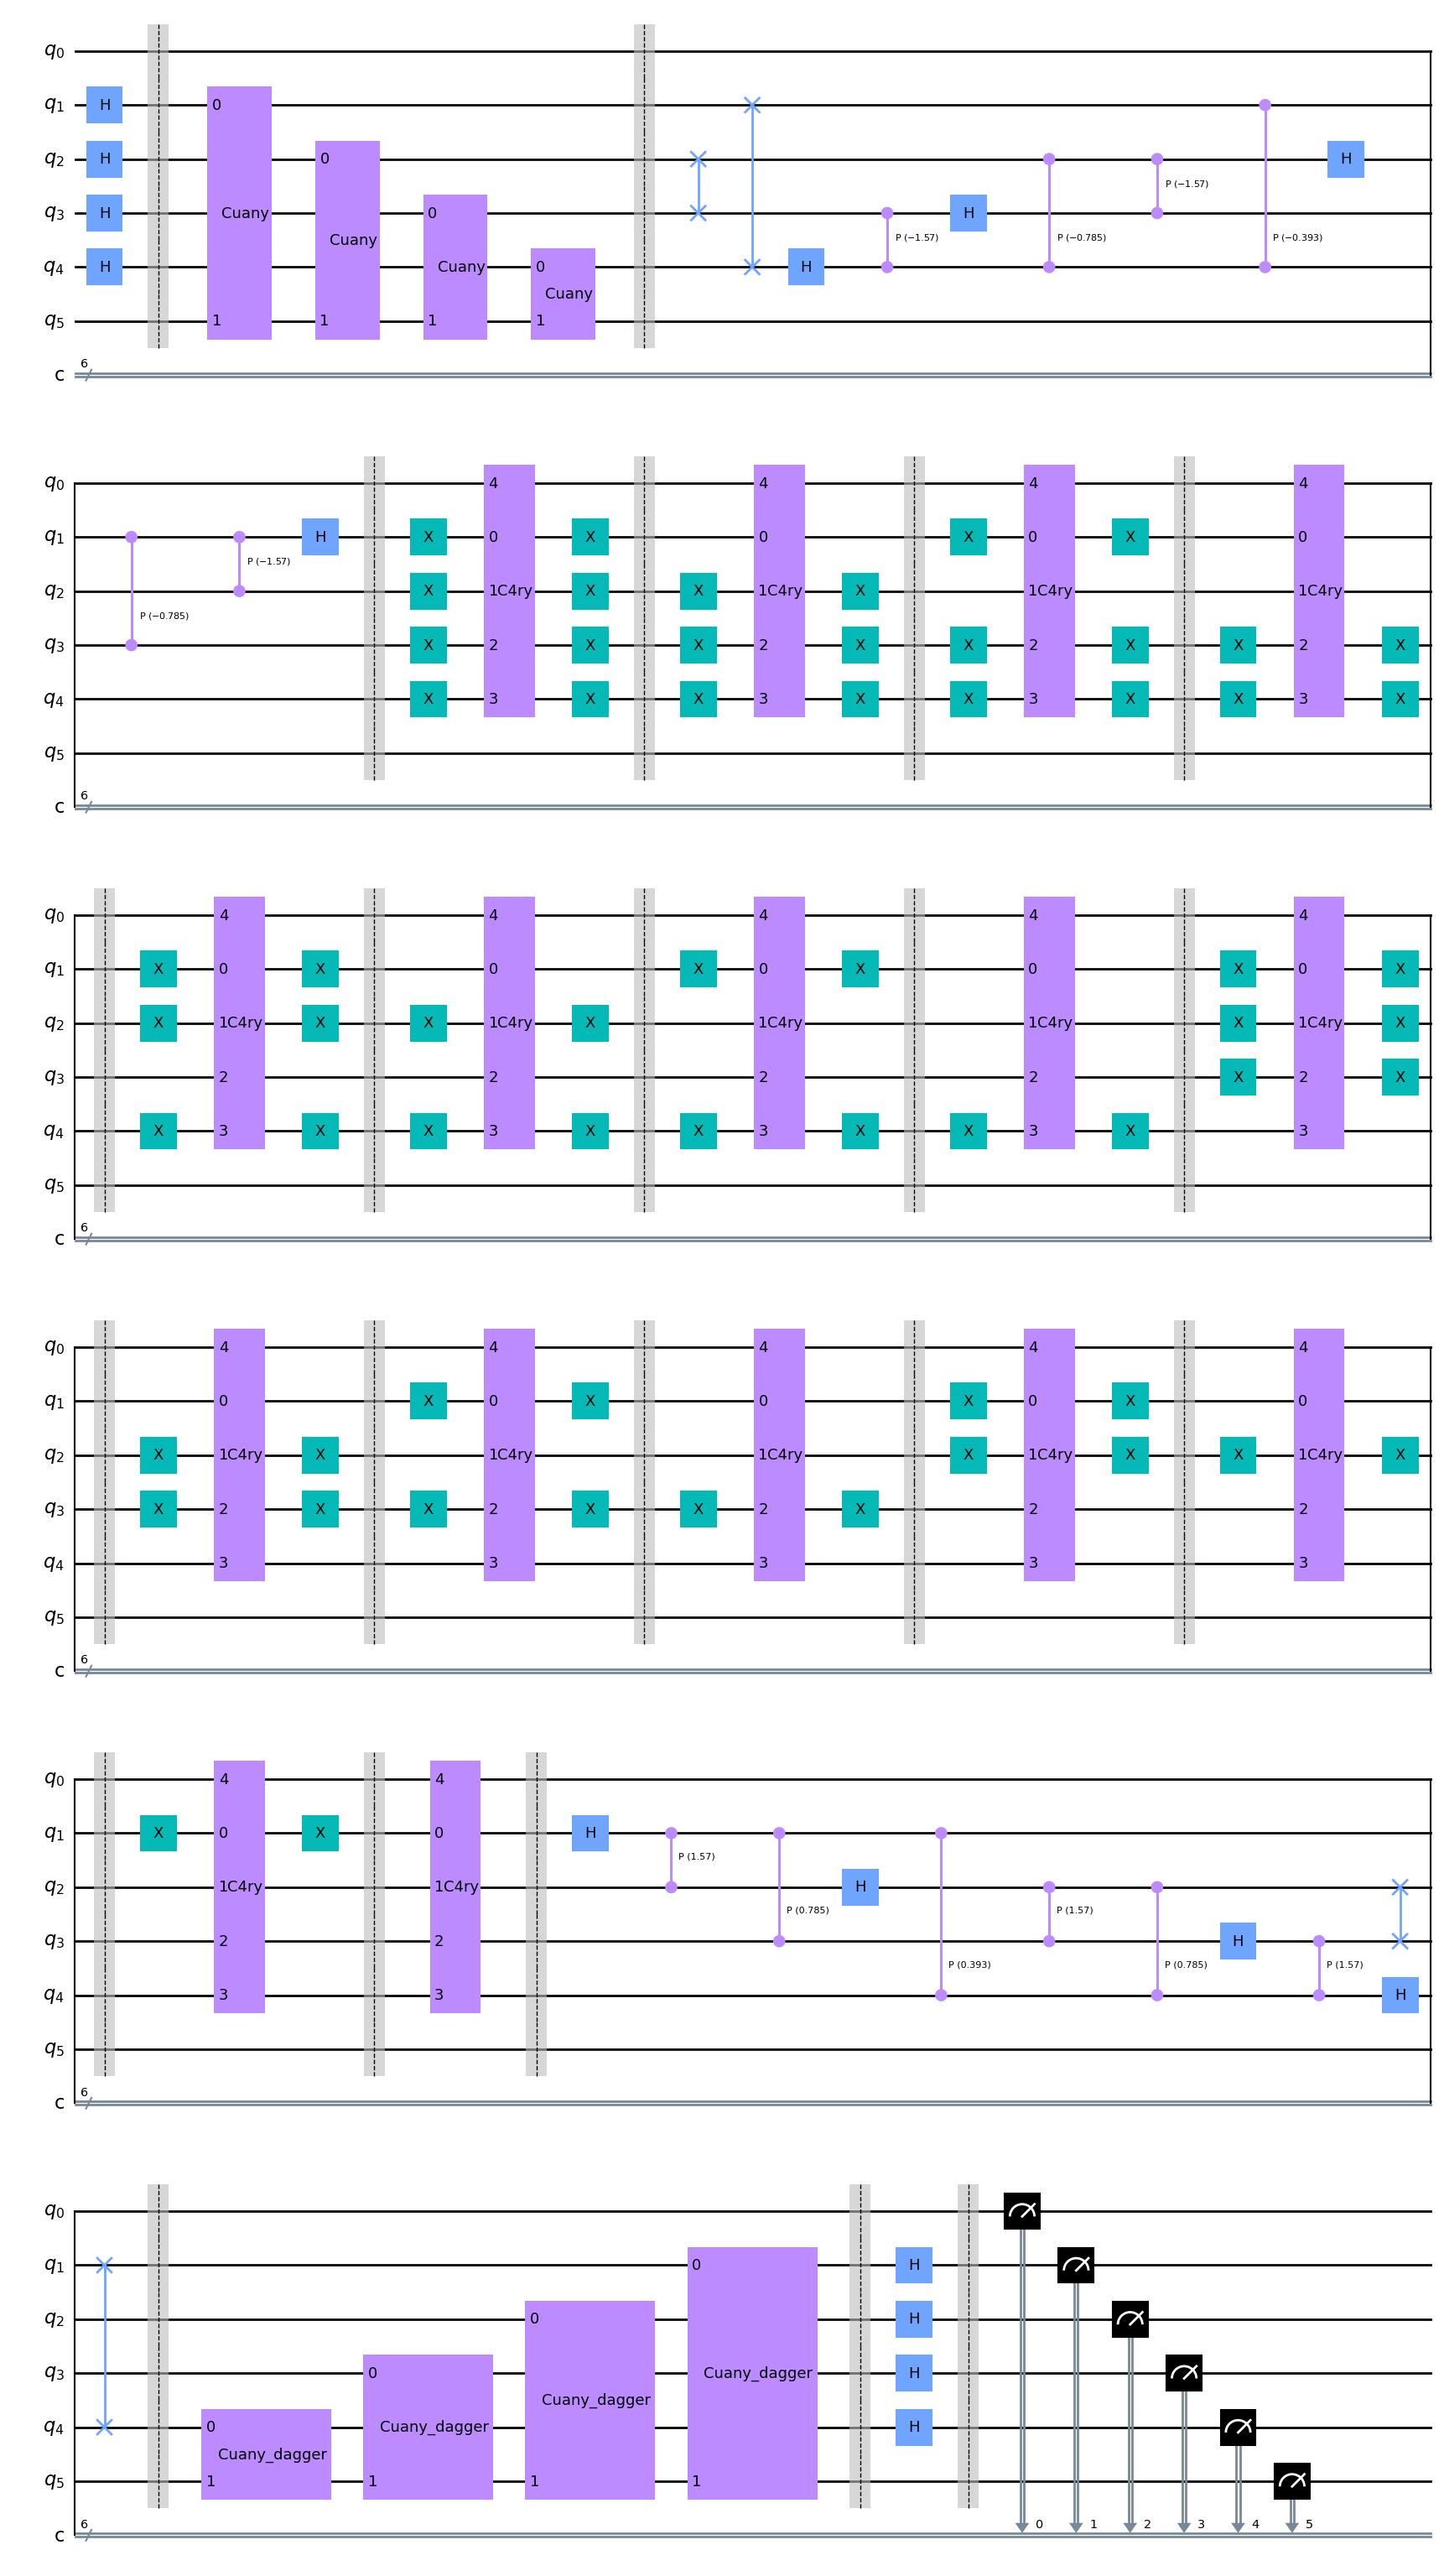

In [5]:
hhl.draw() #画出线路

## 7.附录
[1] Harrow A W, Hassidim A, Lloyd S. Quantum algorithm for linear systems of equations[J]. Physical review letters, 2009, 103(15): 150502.

[2] Shewchuk J R. An introduction to the conjugate gradient method without the agonizing pain[J]. 1994.